In [66]:
import pandas as pd
import numpy as np
import os
import re

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import altair as alt
from sqlalchemy import create_engine

In [67]:
%load_ext sql
%sql sqlite:///C:/sqlite/chicago-taxi.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [68]:
%%sql
SELECT * FROM taxi_trips
LIMIT 5

 * sqlite:///C:/sqlite/chicago-taxi.db
Done.


unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type
unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type
3696bb7f386062eb3f42a48ae2a7df55cb290853,2022-09-30 23:30:00 UTC,2022-09-30 23:45:00 UTC,596,2.54,21,14,POINT (-87.7112105933 41.9386661962),POINT (-87.7215590627 41.968069),9.5,Cash
5b91f49428e134433e329c3b133b5a73fc466287,2022-09-30 12:45:00 UTC,2022-09-30 13:15:00 UTC,1740,8.8,40,8,POINT (-87.6179313803 41.7923572233),POINT (-87.6333080367 41.899602111),26.25,Unknown
646a2313684586b725de9618521a8bc359d1e91f,2022-09-30 04:30:00 UTC,2022-09-30 04:45:00 UTC,682,10.52,49,28,POINT (-87.6233665115 41.7065878819),POINT (-87.6635175498 41.874005383),27.75,Prcard
657349caf048dfc4f60d90eaace7aba71a739296,2022-09-30 15:15:00 UTC,2022-09-30 15:30:00 UTC,360,0.8,4,4,POINT (-87.6875155152 41.9751709433),POINT (-87.6875155152 41.9751709433),5.75,Cash


In [69]:
# set db and table
db_path = "sqlite:///C:/sqlite/chicago-taxi.db"
table = "taxi_trips"

# connect to the db, read the table and pass it into a dataframe
engine = create_engine(db_path)

df = pd.read_sql(f"SELECT * FROM {table}", engine)
df = df.drop(index=0)

# display the first five rows
display(df.head(), df.shape)

,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type
1,3696bb7f386062eb3f42a48ae2a7df55cb290853,2022-09-30 23:30:00 UTC,2022-09-30 23:45:00 UTC,596,2.54,21,14,POINT (-87.7112105933 41.9386661962),POINT (-87.7215590627 41.968069),9.5,Cash
2,5b91f49428e134433e329c3b133b5a73fc466287,2022-09-30 12:45:00 UTC,2022-09-30 13:15:00 UTC,1740,8.8,40,8,POINT (-87.6179313803 41.7923572233),POINT (-87.6333080367 41.899602111),26.25,Unknown
3,646a2313684586b725de9618521a8bc359d1e91f,2022-09-30 04:30:00 UTC,2022-09-30 04:45:00 UTC,682,10.52,49,28,POINT (-87.6233665115 41.7065878819),POINT (-87.6635175498 41.874005383),27.75,Prcard
4,657349caf048dfc4f60d90eaace7aba71a739296,2022-09-30 15:15:00 UTC,2022-09-30 15:30:00 UTC,360,0.8,4,4,POINT (-87.6875155152 41.9751709433),POINT (-87.6875155152 41.9751709433),5.75,Cash
5,462918ee530c76e7a534a0bebffe0c480bf4ffb8,2022-10-31 15:30:00 UTC,2022-10-31 16:00:00 UTC,960,6.4,39,28,POINT (-87.5961833442 41.8089162826),POINT (-87.6635175498 41.874005383),19.25,Unknown


(4072975, 11)

In [70]:
df.isnull().sum()

unique_key                0
trip_start_timestamp      0
trip_end_timestamp        0
trip_seconds              0
trip_miles                0
pickup_community_area     0
dropoff_community_area    0
pickup_location           0
dropoff_location          0
fare                      0
payment_type              0
dtype: int64

In [71]:
df["trip_seconds"] = df["trip_seconds"].astype("int64")
df["trip_minutes"] = round((df["trip_seconds"]/60), 2)

df.head(3)

ValueError: invalid literal for int() with base 10: ''

In [72]:
display(df[df["trip_seconds"]==""].head(2))

,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type
125,20ebfe2de42ce79837cac6154f67489224a97c0d,2022-11-16 14:45:00 UTC,2022-11-19 11:30:00 UTC,,16.77,63,76,POINT (-87.6964352325 41.795430631),POINT (-87.913624596 41.9802643146),65.0,Cash
3057,6294bf48d0196e41e40e3e73b532244505ff3b05,2022-11-05 10:15:00 UTC,2022-11-07 04:30:00 UTC,,0.0,8,76,POINT (-87.6321092196 41.9002656868),POINT (-87.9030396611 41.9790708201),3.25,Cash


In [73]:
# convert trip_seconds from seconds to minutes
df["trip_seconds"] = pd.to_numeric(df["trip_seconds"], errors="coerce")
df["trip_minutes"] = round((df["trip_seconds"]/60), 2)

df.head(3)

,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type,trip_minutes
1,3696bb7f386062eb3f42a48ae2a7df55cb290853,2022-09-30 23:30:00 UTC,2022-09-30 23:45:00 UTC,596.0,2.54,21,14,POINT (-87.7112105933 41.9386661962),POINT (-87.7215590627 41.968069),9.5,Cash,9.93
2,5b91f49428e134433e329c3b133b5a73fc466287,2022-09-30 12:45:00 UTC,2022-09-30 13:15:00 UTC,1740.0,8.8,40,8,POINT (-87.6179313803 41.7923572233),POINT (-87.6333080367 41.899602111),26.25,Unknown,29.00
3,646a2313684586b725de9618521a8bc359d1e91f,2022-09-30 04:30:00 UTC,2022-09-30 04:45:00 UTC,682.0,10.52,49,28,POINT (-87.6233665115 41.7065878819),POINT (-87.6635175498 41.874005383),27.75,Prcard,11.37


In [74]:
df.isnull().sum()

unique_key                  0
trip_start_timestamp        0
trip_end_timestamp          0
trip_seconds              965
trip_miles                  0
pickup_community_area       0
dropoff_community_area      0
pickup_location             0
dropoff_location            0
fare                        0
payment_type                0
trip_minutes              965
dtype: int64

In [75]:
# read geojson chicago
chicago_path = "../dataset/Boundaries - Community Areas (current).geojson"
boundaries = gpd.read_file(chicago_path)
boundaries = boundaries[["community", "geometry"]]

boundaries.head()

,community,geometry
0,DOUGLAS,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [76]:
# change into a tittle case
boundaries["community"] = boundaries["community"].apply(lambda x: x.title())

boundaries.head(3)

,community,geometry
0,Douglas,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,Oakland,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,Fuller Park,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."


<Axes: >

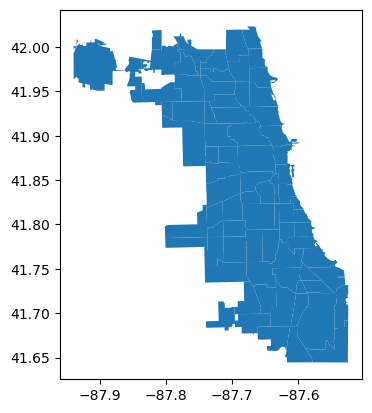

In [77]:
boundaries.plot()

In [90]:
boundaries.shape

(77, 2)

perform spatial joins

In [78]:
df["pickup_location"] = df["pickup_location"].apply(Point)

points = gpd.GeoDataFrame(df, geometry="pickup_location")

TypeError: iteration over a 0-d array

In [79]:
display(df[df["pickup_location"]==""].head(2))

,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type,trip_minutes
86578,35772006656fcffae5fc02eaa1e90ec8ea2a6677,2022-09-30 16:00:00 UTC,2022-09-30 16:15:00 UTC,619.0,4.32,,,,,13.5,Credit Card,10.32
86579,4840e16877ca0eb052670e4a30e9a4a259a675bb,2022-10-31 08:15:00 UTC,2022-10-31 09:00:00 UTC,2601.0,20.68,,7,,POINT (-87.6494887289 41.9226862843),52.76,Cash,43.35


In [80]:
df = df[(df["pickup_location"]=="")==False]

display(df[df["pickup_location"]==""].head(2))

,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type,trip_minutes


In [81]:
df["pickup_location"] = df["pickup_location"].apply(Point)

points = gpd.GeoDataFrame(df, geometry="pickup_location")

TypeError: iteration over a 0-d array

In [82]:
mask = ~df["pickup_location"].isnull()

def parse_point(point_str):
    # extract the coordinates
    match = re.match(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)', point_str)
    if match:
        # create point
        return Point(float(match.group(1)), float(match.group(2)))
    else:
        return None
    
df.loc[mask, "pickup_location"] = df.loc[mask, "pickup_location"].apply(parse_point)
df.loc[mask, "dropoff_location"] = df.loc[mask, "dropoff_location"].apply(parse_point)

points = gpd.GeoDataFrame(df, geometry="pickup_location")

In [85]:
joined_df = gpd.tools.sjoin(points, boundaries, predicate="within", how='left')
joined_df = joined_df.rename(columns={"community":"pickup_community"})
joined_df = joined_df.drop(["index_right"], axis=1)

joined_df.head(2)

C:\Users\PF2L6BL6\AppData\Local\Temp\ipykernel_11252\701443741.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_df = gpd.tools.sjoin(points, boundaries, predicate="within", how='left')


,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type,trip_minutes,pickup_community
1,3696bb7f386062eb3f42a48ae2a7df55cb290853,2022-09-30 23:30:00 UTC,2022-09-30 23:45:00 UTC,596.0,2.54,21,14,POINT (-87.71121 41.93867),POINT (-87.7215590627 41.968069),9.5,Cash,9.93,Avondale
2,5b91f49428e134433e329c3b133b5a73fc466287,2022-09-30 12:45:00 UTC,2022-09-30 13:15:00 UTC,1740.0,8.8,40,8,POINT (-87.61793 41.79236),POINT (-87.6333080367 41.899602111),26.25,Unknown,29.00,Washington Park


In [86]:
points2 = gpd.GeoDataFrame(joined_df, geometry="dropoff_location")

joined_df2 = gpd.tools.sjoin(points2, boundaries, predicate="within", how='left')
joined_df2 = joined_df2.rename(columns={"community":"dropoff_community"})
joined_df2 = joined_df2.drop(["index_right"], axis=1)

joined_df2.head(2)

C:\Users\PF2L6BL6\AppData\Local\Temp\ipykernel_11252\4119031663.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_df2 = gpd.tools.sjoin(points2, boundaries, predicate="within", how='left')


,unique_key,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_location,dropoff_location,fare,payment_type,trip_minutes,pickup_community,dropoff_community
1,3696bb7f386062eb3f42a48ae2a7df55cb290853,2022-09-30 23:30:00 UTC,2022-09-30 23:45:00 UTC,596.0,2.54,21,14,POINT (-87.71121 41.93867),POINT (-87.72156 41.96807),9.5,Cash,9.93,Avondale,Albany Park
2,5b91f49428e134433e329c3b133b5a73fc466287,2022-09-30 12:45:00 UTC,2022-09-30 13:15:00 UTC,1740.0,8.8,40,8,POINT (-87.61793 41.79236),POINT (-87.63331 41.89960),26.25,Unknown,29.00,Washington Park,Near North Side


In [91]:
joined_df2["pickup_community"].nunique()

77